## **Open Rituals**

Import needed package and define paths and useful functions

In [31]:
#%% open rituals ##############################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from pandas import MultiIndex, Int64Index
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from hyperopt import Trials
import pandas as pd
import xgboost as xgb
import numpy as np
import optuna
import spotpy
import shap
import math
import pickle
import os


### replace this main directory with your own
Path_Main = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project\Model_with_SoilGrid'
Path_Plot = os.path.join(Path_Main, 'plot')
Path_Output = os.path.join(Path_Main, 'output')
Path_Shape = os.path.join(Path_Main, 'shape')
Path_Input = os.path.join(Path_Main, 'input')
Path_Input_old = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project\Data'
Path_Shape_old = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project\shape'
Path_Soilgrid = r'C:\Users\lli55\Desktop\Lingbo Li PhD\SoilGrid\data'

### KGE for model training
def kge_2009(preds, Dtrain):
    y = Dtrain.get_label()
    kge = spotpy.objectivefunctions.kge(y, preds)
    if math.isnan(kge):
        kge_1 = -9999
    else:
        kge_1 = kge
    return 'kge', kge_1

## KGE for plotting
def kge_2009_p(preds, obs):
    return spotpy.objectivefunctions.kge(obs, preds)

## func for CDF plot in representative checking
def my_range(start, end, how_many):
    incr = float(end - start)/(how_many-1)
    return [start + i*incr for i in range(how_many)]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## **Variable Selection**
Here the feature selection is based on the pr calculated using SOC from SoilGrid2.0 

In [ ]:
### step one: read and process the data #######################################
data = pd.read_csv(os.path.join(Path_Input, 'train_set.txt'), sep= '\t')
## Duo to the missing SOC data in SoilGrid2.0, we can not get valid value for 12 previous training stations 
data = data.dropna(subset = 'pr_soilgrid').reset_index(drop = True)
feature = data.columns[:-3]
## log transformation to the target value pr. Here pr calcuated using SOC from soilgrid is used
X, Y = data[feature].copy(), np.log10(data['pr_soilgrid'])

## introducing a randomly generated attributes into model
np.random.seed(0)
random = np.random.rand(len(X),1) 
power = PowerTransformer(method='yeo-johnson', standardize=True)
trans_random = power.fit_transform(random)
X['rand'] = trans_random
Xx = X.copy()

In [ ]:
### repeat step two to six till no feature can be dropped #####################
### step two: define the objective function ###################################
X_train, X_test, Y_train, Y_test = train_test_split(Xx, Y, test_size=0.3, random_state=1)
Dtrain = xgb.DMatrix(X_train, label = Y_train)
Dtest = xgb.DMatrix(X_test, label = Y_test)

### define the objective funtion for optuna ###################################
def objective_xgb(trial):     
    param = {
        'booster':'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 10), # default value = 1
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10), # default value = 0
        'gamma': trial.suggest_loguniform('gamma', 1e-2, 10), # default value = 0
        'eta': trial.suggest_loguniform('eta', 1e-4, 1.0), # default value = 0.3
        'max_delta_step': trial.suggest_loguniform('max_delta_step', 1, 10), # default value = 0
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 10), # default value = 1
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 5e-1, 1), # default value = 1
        'subsample': trial.suggest_loguniform('subsample', 5e-1, 1), # default value = 1
        'max_depth': trial.suggest_int('max_depth', 2, 10), # default value = 6  
        'disable_default_eval_metric':1
    }
    ## put this into callback if you want to monitor the details
    # xgb.callback.EvaluationMonitor(show_stdv=False)
    xgb_cv_results = xgb.cv(param,
                    Dtrain,
                    num_boost_round=500,
                    seed=42,
                    nfold=5,
                    maximize = True, 
                    feval = kge_2009,   
                    callbacks=[
                        # xgb.callback.EvaluationMonitor(show_stdv=False),
                        xgb.callback.EarlyStopping(rounds = 50,
                                                          metric_name = 'kge',
                                                          maximize = True)],   
                    verbose_eval=False)     
                      
    kge_ = xgb_cv_results.iloc[-1]['test-kge-mean'] 
    trial.set_user_attr('n_estimators', len(xgb_cv_results))                      
    return kge_

In [ ]:
## step three:optuna learning process #########################################
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize',sampler=TPESampler(seed=42))
study.optimize(objective_xgb, n_trials=200, show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
best_param = study.best_trial.params
best_param['booster'] = 'gbtree'
best_param['disable_default_eval_metric'] = 1
n_estimators = study.best_trial.user_attrs['n_estimators']
early_stop = int(n_estimators/10)

## CV to get the rigorois result of model preformance #########################
optimised_xgb = xgb.train(
                          best_param, 
                          Dtrain, 
                          num_boost_round=n_estimators, 
                          evals = [(Dtrain, 'eval_train'), (Dtest, 'eval_test')],
                          feval=kge_2009,
                          maximize = True,        
                          callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                                     xgb.callback.EarlyStopping(rounds = early_stop,
                                                                metric_name = 'kge',
                                                                maximize = True)],   
                          verbose_eval=False
                          ) 

predicted_mean_train = optimised_xgb.predict(Dtrain, iteration_range=(0, optimised_xgb.best_iteration+1))
predicted_mean_test  = optimised_xgb.predict(Dtest, iteration_range=(0, optimised_xgb.best_iteration+1))

## train/test scores of pr in log scale
print('trainning_score:' + str(kge_2009(predicted_mean_train, Dtrain)))
print('testing_score:' + str(kge_2009(predicted_mean_test, Dtest)))
## train/test scores of pr in original scale
print('trainning_score_normal:', kge_2009_p([10**i for i in predicted_mean_train], [10**i for i in Y_train]))
print('testing_score_normal:' + str(kge_2009_p([10**i for i in predicted_mean_test], [10**i for i in Y_test])))
print(best_param)

In [ ]:
### step 5 visulization: performance at testing ###############################
path_feature_selection = os.path.join(Path_Plot, 'feature_selection')
name = '8th'
obs = [10**i for i in Y_test]
sim = [10**i for i in predicted_mean_test]
x = np.arange(0, 1e-2, 1e-4)
fig = plt.figure(1, (7,7))
ax = plt.gca()
ax.scatter(obs, sim, label = "Sim Vs Obs", ec = 'k', fc = 'steelblue', linewidth = 0.5, alpha = 0.75)
ax.plot(x,x, label = "1:1 line", c = 'r')
ax.legend(loc = 'best')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5, 1e-2)
ax.set_ylim(1e-5, 1e-2)
ax.set_xlabel('Observation')
ax.set_ylabel('Simulation')
ax.text(3e-3, 1.3e-5,'KGE:' + str("{:.3f}".format(kge_2009(predicted_mean_test, Dtest)[1])), style='italic')
ax.text(3e-3, 2e-5,'KGE_N:' + str("{:.3f}".format(kge_2009_p(sim, obs))), style='italic')
ax.set_title(name + '_run_performance')
fig.savefig(os.path.join(path_feature_selection, name + '_run_performance.png'), dpi = 400)

In [ ]:
### step 5 visulization: feature importance (only those important than rand)###
explainer = shap.TreeExplainer(optimised_xgb)
shap_values = explainer.shap_values(Xx)
shap_sum = np.abs(shap_values).mean(axis=0)
## It's recommanded to save the feature importance of each iterations
importance_df = pd.DataFrame([Xx.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False).reset_index(drop = True)
importance_rand = importance_df[importance_df['column_name'] == 'rand']['shap_importance'].values[0]
keep = [ i for i in importance_df[importance_df['shap_importance']>= importance_rand]['column_name']]
shap.summary_plot(shap_values, Xx, plot_type='bar',max_display=len(keep),show = False)
plt.savefig(os.path.join(path_feature_selection, name + '_run_improtance.png'),dpi = 400, bbox_inches='tight')

In [ ]:
### step 6: only preserve features with importance higher than rand ###########
Xx = Xx[keep]
print(keep)

## **Representative check**
- Feature selection yeilds the following important features: ['TOT_A', 'TOT_NLCD01_90', 'TOT_CONTACT', 'TOT_B', 'TOT_I', 'TOT_BFI', 'TOT_E', 'TOT_CLAYAVE', 'TOT_HGB', 'TOT_NLCD01_42', 'TOT_NLCD01_95', 'TOT_CNPY11_BUFF100', 'TOT_HGBD']
- We need to further check if those predictors at training catchment are representative enough in CONUS domain
- Representative is done through comparing the distribution and percentiles of those predictors in conus and training catchment

In [ ]:
#%% representative checking ###################################################
## read in the preprocessed predictors for training, evaluation, and prediction 
all_data = pd.read_csv(os.path.join(Path_Input, 'original_attributes.txt'), delimiter= '\t').replace(-9999.0, np.nan) 
## corr.pkl contains the information of 9 correlation groups
with open(os.path.join(Path_Input, 'corr.pkl'), 'rb') as f:
    corr = pickle.load(f)

selected_dependent_columns = ['TOT_NLCD01_90', 'TOT_CONTACT', 'TOT_BFI', 'TOT_CLAYAVE', 'TOT_HGB', 'TOT_NLCD01_42', 'TOT_NLCD01_95', 'TOT_CNPY11_BUFF100', 'TOT_HGBD']

all_data_r = all_data[selected_dependent_columns]
all_data_r['TOT_A'] = all_data[corr[1][0]].mean(axis=1, skipna=False)
all_data_r['TOT_B'] = all_data[corr[1][1]].mean(axis=1, skipna=False)
all_data_r['TOT_I'] = all_data[corr[1][9]].mean(axis=1, skipna=False)
all_data_r['TOT_E'] = all_data[corr[1][5]].mean(axis=1, skipna=False)
all_data_r['label'] = all_data['label']
all_data_r['COMID'] = all_data['COMID']

rep_conus = all_data_r[all_data_r['label'] == 'predict'].reset_index(drop = True)
rep_conus.to_csv(os.path.join(Path_Output, 'rep_conus.txt'), sep = '\t', index = None)

rep_select = all_data_r[all_data_r['label'] == 'train'].reset_index(drop = True)
''' 
Out of the previous 2595 training catchments (using HWSD), 12 catchments could not yield a valid PR due to missing values in the SoilGrid SOC data. As a result, we have to exclude these sites from the representativeness check. The following four lines are not necessary for the model using HWSD.
'''
pr_selected = pd.read_csv(os.path.join(Path_Input, 'train_set.txt'), sep= '\t')[['COMID', 'pr_hwsd', 'pr_soilgrid']]
rep_select = rep_select.merge(pr_selected, on = 'COMID', how = 'left')
rep_select = rep_select.dropna().reset_index(drop = True)
rep_select = rep_select.drop(columns=['pr_hwsd','pr_soilgrid'])
rep_select.to_csv(os.path.join(Path_Output, 'rep_select.txt'), sep = '\t', index = None)

invalid value encountered in divide


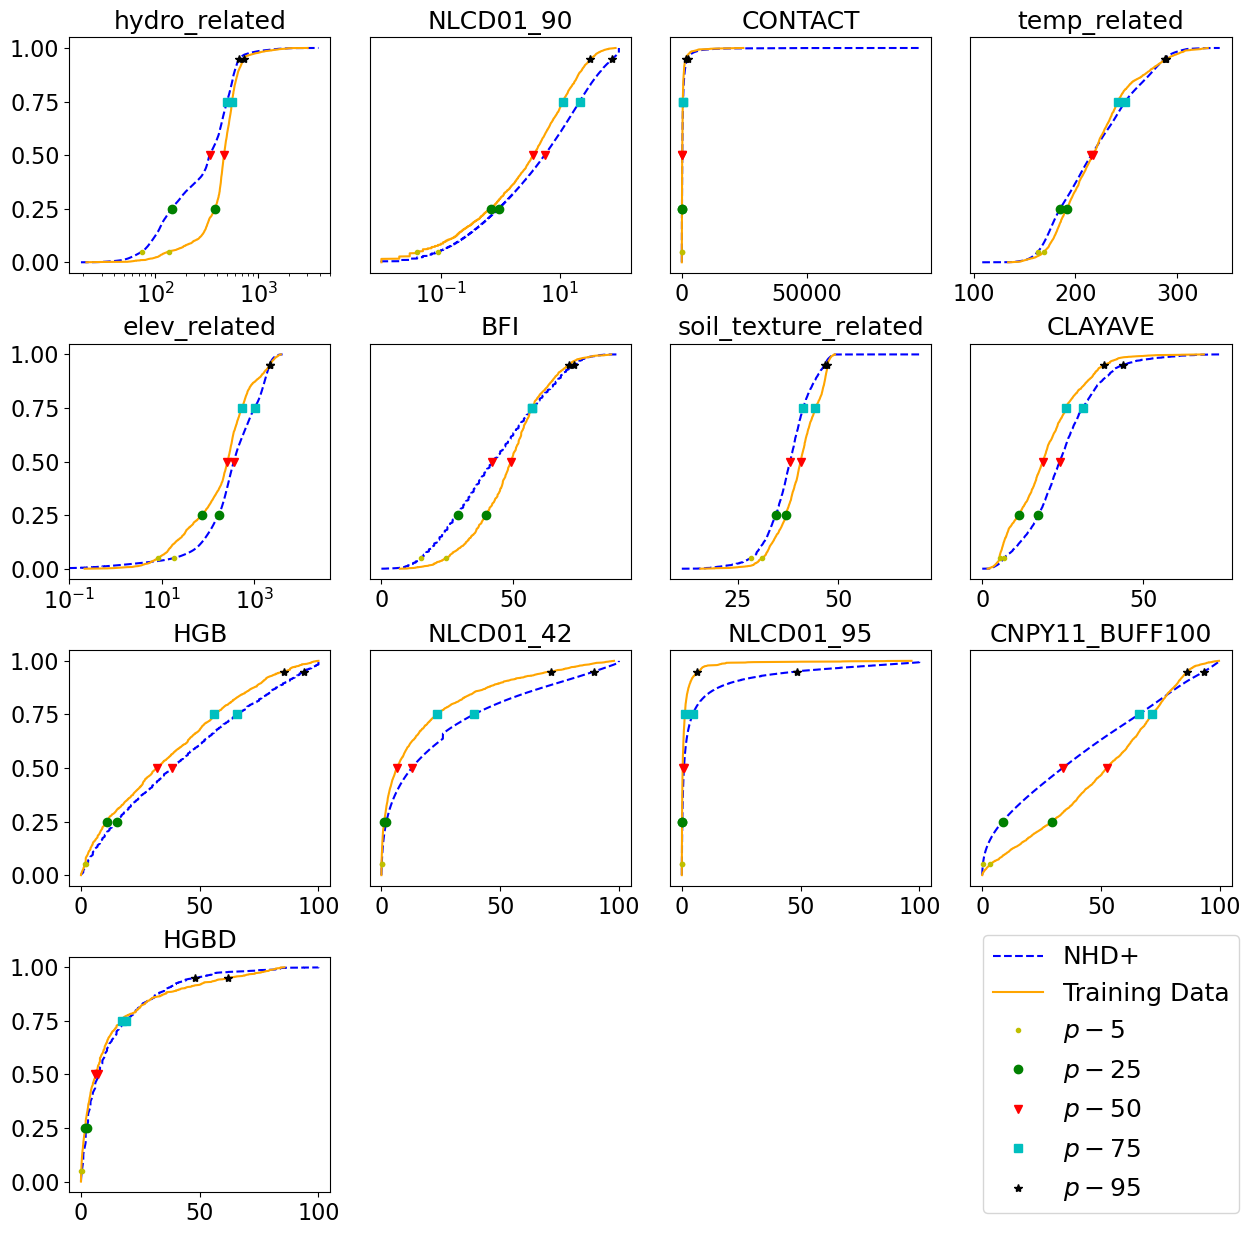

In [33]:
#%% representative plot 
attr_sites = pd.read_csv(os.path.join(Path_Output,'rep_select.txt'), delimiter= '\t')
attr_flowlines = pd.read_csv(os.path.join(Path_Output, 'rep_conus.txt'), delimiter= '\t').replace(np.nan, -9999.0)
columns_tot =  ['TOT_A', 'TOT_NLCD01_90', 'TOT_CONTACT', 'TOT_B', 'TOT_I', 'TOT_BFI', 'TOT_E', 'TOT_CLAYAVE', 'TOT_HGB', 'TOT_NLCD01_42', 'TOT_NLCD01_95', 'TOT_CNPY11_BUFF100', 'TOT_HGBD']

title = ['hydro_related', 'NLCD01_90', 'CONTACT' , 'temp_related', 'elev_related', 'BFI', 'soil_texture_related', 'CLAYAVE', 'HGB', 'NLCD01_42', 'NLCD01_95', 'CNPY11_BUFF100', 'HGBD']

fig, axs = plt.subplots(4,4, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.15)
quantile = ['$p-5$','$p-25$','$p-50$','$p-75$','$p-95$']
quantiles = [0.05,0.25,0.5,0.75,0.95]
log_list = [0, 1, 4, 13]
marker = ['.','o','v','s','*']
color = ['y','g','r','c','k']
quantile_ndhp = np.zeros((13,5))
quantile_select = np.zeros((13,5))
axs = axs.ravel()

for i in range(13):
    x_all_flowline_1 = sorted([i for i in attr_flowlines[columns_tot[i]] if i != -9999.0])
    ## zero values are excluded in representative checking as XGBoost have self-aware for sparse data, which can handle both missing and larger portion of zero values
    x_all_flowline = [i for i in x_all_flowline_1 if i != 0]
    y_all_flowline = my_range(0,1,len(x_all_flowline))
    
    x_selected_site_1 = attr_sites.sort_values(by=[columns_tot[i]])[columns_tot[i]]
    x_selected_site = [i for i in x_selected_site_1 if i not in [0]]
    y_selected_site = my_range(0,1,len(x_selected_site))
    axs[i].plot(x_all_flowline, y_all_flowline, 'b--', label = 'NHD+')
    axs[i].plot(x_selected_site, y_selected_site, '-', color = 'orange', label = 'Training Data')
    q_nhd = np.quantile(x_all_flowline, [0.05, 0.25, 0.5, 0.75, 0.95])
    quantile_ndhp[i] = q_nhd
    q_selected = np.quantile(x_selected_site, [0.05, 0.25, 0.5, 0.75, 0.95])
    quantile_select[i] = q_selected
    for j in range(5):
        if q_nhd[j] != 0:
            axs[i].plot(q_nhd[j],quantiles[j],marker[j]+color[j],label = quantile[j])
    for k in range(5):        
        if q_selected[k] != 0:
            axs[i].plot(q_selected[k],quantiles[k],marker[k]+color[k])
    axs[i].set_title(title[i])
    axs[i].title.set_fontsize(18)
    axs[i].yaxis.label.set_fontsize(16)
    axs[i].tick_params(axis='x', labelsize=16) 
    axs[i].tick_params(axis='y', labelsize=16)
    if i in log_list:
        axs[i].set_xscale('log')
    if i not in [0, 4, 8, 12]:
        axs[i].set_yticks([])

lines, labels = fig.axes[1].get_legend_handles_labels() 
axs[15].legend(lines, labels, loc='center left', prop = {'size' : 18})
axs[15].axis('off')
axs[14].axis('off')
axs[13].axis('off')
axs[4].set_xlim(left=0.1)
fig.savefig(os.path.join(Path_Plot,'representative.png'),dpi = 600, bbox_inches='tight')
## save this ratio information
ratio = 2*np.abs(quantile_ndhp - quantile_select)/(quantile_ndhp + quantile_select)